In [1]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scikeras.wrappers import KerasRegressor

In [16]:
path = './Files/After_Feature_Engineering/Split/'

In [19]:
def label_encoder(Y_train, Y_test):
    """
    Encode categorical labels using LabelEncoder and convert them to one-hot encoding.

    Parameters:
        Y_train (pandas.DataFrame): Training labels.
        Y_test (pandas.DataFrame): Testing labels.

    Returns:
        Tuple of encoded and one-hot encoded labels for nail spacing, number of sheathing panels,
        number of end studs, as well as the original Y_train and Y_test.
    """
    # Encode and one-hot encode 'Nail spacing [cm]'
    label_encoder_nail_spacing = LabelEncoder()
    Y_train['Nail spacing [cm]'] = label_encoder_nail_spacing.fit_transform(Y_train['Nail spacing [cm]'])
    Y_test['Nail spacing [cm]'] = label_encoder_nail_spacing.transform(Y_test['Nail spacing [cm]'])
    Y_train_onehot_nail_spacing = to_categorical(Y_train['Nail spacing [cm]'], num_classes=3)
    Y_test_onehot_nail_spacing = to_categorical(Y_test['Nail spacing [cm]'], num_classes=3)

    # Encode and one-hot encode 'Number sheathing panels'
    label_encoder_num_sheathing_panels = LabelEncoder()
    Y_train['Number sheathing panels'] = label_encoder_num_sheathing_panels.fit_transform(Y_train['Number sheathing panels'])
    Y_test['Number sheathing panels'] = label_encoder_num_sheathing_panels.transform(Y_test['Number sheathing panels'])
    Y_train_onehot_num_sheathing_panels = to_categorical(Y_train['Number sheathing panels'], num_classes=2)
    Y_test_onehot_num_sheathing_panels = to_categorical(Y_test['Number sheathing panels'], num_classes=2)

    # Encode and one-hot encode 'Number end studs'
    label_encoder_num_end_studs = LabelEncoder()
    Y_train['Number end studs'] = label_encoder_num_end_studs.fit_transform(Y_train['Number end studs'])
    Y_test['Number end studs'] = label_encoder_num_end_studs.transform(Y_test['Number end studs'])
    Y_train_onehot_num_end_studs = to_categorical(Y_train['Number end studs'], num_classes=6)
    Y_test_onehot_num_end_studs = to_categorical(Y_test['Number end studs'], num_classes=6)

    # Return the results
    return (
        Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing,
        Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels,
        Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs,
        Y_train, Y_test
    )


def plot_loss(history):
    """
    Plot training and validation loss over epochs.
    Uses logarithmic scale for the x-axis for better visualization.

    Parameters:
        history (keras.callbacks.History): The training history obtained from model training.

    Returns:
        None
    """
    plt.figure(figsize=(15, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    for output in history.history.keys():
        if output.endswith('loss') and not output.startswith('val_') and output != 'loss':
            plt.plot(history.history[output], label=output)

    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation loss
    plt.subplot(1, 2, 2)
    for output in history.history.keys():
        if output.startswith('val_') and output.endswith('loss') and output != 'val_loss':
            plt.plot(history.history[output], label=output[4:])

    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [32]:
X_train_C_1 = pd.read_csv(path + "X_train_C_part1_FE.csv", low_memory=False)
X_test_C_1 = pd.read_csv(path + "X_test_C_part1_FE.csv", low_memory=False)

Y_train_C_1 = pd.read_csv(path + "Y_train_C_part1_FE.csv", low_memory=False)
Y_test_C_1 = pd.read_csv(path + "Y_test_C_part1_FE.csv", low_memory=False)

In [33]:
# One hot encoding Y
Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing, Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels, Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs, Y_train_C_1, Y_test_C_1 = label_encoder(Y_train_C_1, Y_test_C_1)

Epoch 1/10
1557/1557 [==============================] - 8s 3ms/step - loss: 37.7269 - nail_spacing_loss: 0.8161 - num_sheathing_panels_loss: 0.3916 - num_end_studs_loss: 0.8132 - total_num_studs_loss: 24.1682 - holddown/ats_loss: 11.5378 - nail_spacing_accuracy: 0.6548 - num_sheathing_panels_accuracy: 0.8231 - num_end_studs_accuracy: 0.6951 - total_num_studs_mae: 3.4318 - holddown/ats_mae: 2.2672 - val_loss: 5.8931 - val_nail_spacing_loss: 0.6321 - val_num_sheathing_panels_loss: 0.2665 - val_num_end_studs_loss: 0.4400 - val_total_num_studs_loss: 1.7889 - val_holddown/ats_loss: 2.7656 - val_nail_spacing_accuracy: 0.7355 - val_num_sheathing_panels_accuracy: 0.8884 - val_num_end_studs_accuracy: 0.8304 - val_total_num_studs_mae: 0.8954 - val_holddown/ats_mae: 0.9892 - lr: 0.0010
Epoch 2/10
1557/1557 [==============================] - 4s 2ms/step - loss: 12.4404 - nail_spacing_loss: 0.6785 - num_sheathing_panels_loss: 0.2941 - num_end_studs_loss: 0.5473 - total_num_studs_loss: 5.0957 - hold

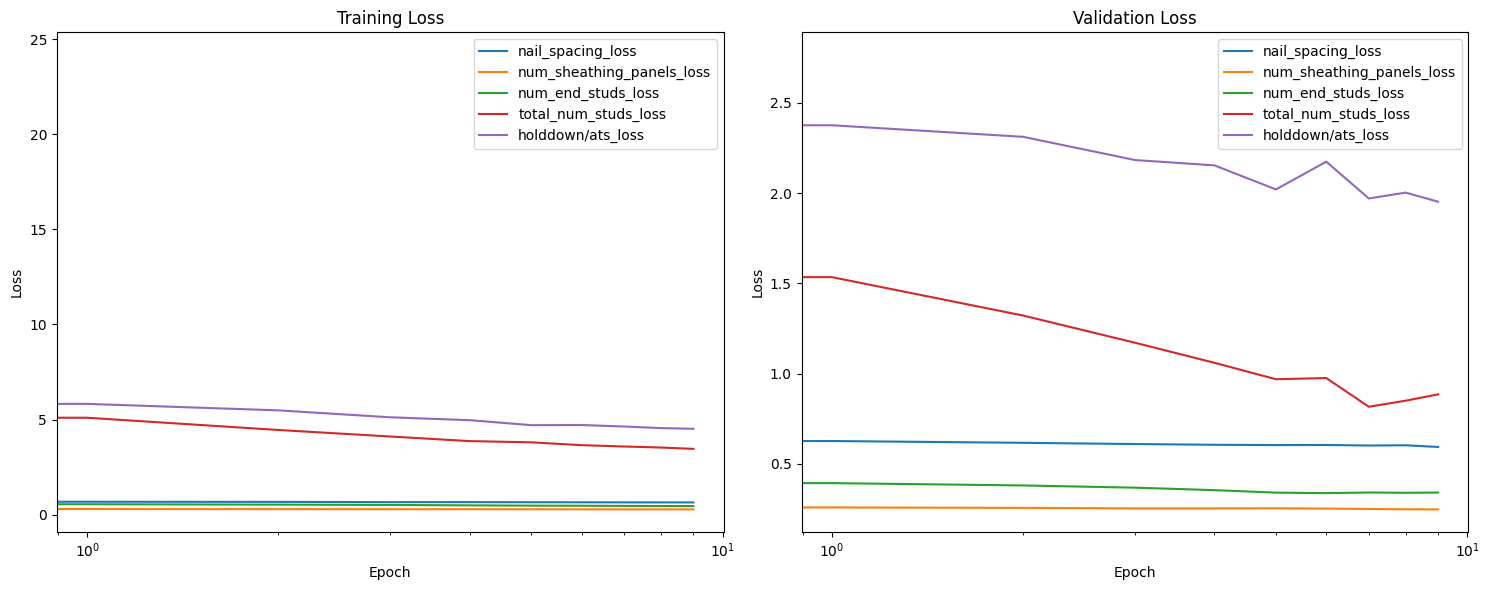

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

def create_model(layer_sizes=[64, 32], dropout_rate=0.5):
    input_layer = Input(shape=(X_train_C_1.shape[1],))
    
    x = input_layer
    for size in layer_sizes:
        x = Dense(size, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Output layers
    nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(x)
    num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(x)
    num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(x)
    total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(x)
    holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(x)

    model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                               num_end_studs_output, total_num_studs_output, 
                                               holddown_model_output])

    model.compile(optimizer='adam', 
                  loss={'nail_spacing': 'categorical_crossentropy',
                        'num_sheathing_panels': 'categorical_crossentropy',
                        'num_end_studs': 'categorical_crossentropy',
                        'total_num_studs': 'mean_squared_error',
                        'holddown/ats': 'mean_squared_error'},
                  metrics={'nail_spacing': 'accuracy',
                           'num_sheathing_panels': 'accuracy',
                           'num_end_studs': 'accuracy',
                           'total_num_studs': 'mae',
                           'holddown/ats': 'mae'})

    return model

# Create the model with specific parameters
model_C_1 = create_model(layer_sizes=[128, 64], dropout_rate=0.3)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model
history_C_1 = model_C_1.fit(
    X_train_C_1, 
    {'nail_spacing': Y_train_onehot_nail_spacing, 
     'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
     'num_end_studs': Y_train_onehot_num_end_studs,
     'total_num_studs': Y_train_C_1['Total number studs'],
     'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                  'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                  'num_end_studs': Y_test_onehot_num_end_studs,
                                  'total_num_studs': Y_test_C_1['Total number studs'],
                                  'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}),
    callbacks=[reduce_lr]
)



plot_loss(history_C_1)

# Optionally, visualize the model structure
plot_model(model_C_1, to_file='model_C_1.png', show_shapes=True)

In [12]:
# Evaluate the model on the test set
evaluation_results = model_C_1.evaluate(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing, 
                                             'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                             'num_end_studs': Y_test_onehot_num_end_studs,
                                             'total_num_studs': Y_test_C_1['Total number studs'],
                                             'holddown/ats': Y_test_C_1['HoldDown Model / ATS']
                                             },
                                    batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_C_1.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

390/390 [==============================] - 1s 1ms/step - loss: 4.0221 - nail_spacing_loss: 0.5940 - num_sheathing_panels_loss: 0.2481 - num_end_studs_loss: 0.3416 - total_num_studs_loss: 0.8855 - holddown/ats_loss: 1.9529 - nail_spacing_accuracy: 0.7483 - num_sheathing_panels_accuracy: 0.8905 - num_end_studs_accuracy: 0.8641 - total_num_studs_mae: 0.6529 - holddown/ats_mae: 0.7942
Metrics on Test Set:
loss: 4.022105693817139
nail_spacing_loss: 0.5940413475036621
num_sheathing_panels_loss: 0.24806250631809235
num_end_studs_loss: 0.341557115316391
total_num_studs_loss: 0.8855481147766113
holddown/ats_loss: 1.9528963565826416
nail_spacing_accuracy: 0.748333752155304
num_sheathing_panels_accuracy: 0.8905484676361084
num_end_studs_accuracy: 0.8641291260719299
total_num_studs_mae: 0.6529072523117065
holddown/ats_mae: 0.7942308187484741


In [34]:
import kerastuner as kt
from tensorflow import keras
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model

def build_model(hp):
    input_layer = Input(shape=(X_train_C_1.shape[1],))
    x = input_layer

    # Tune the number of layers and their sizes
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(units=hp.Int('units_' + str(i),
                               min_value=32,
                               max_value=128,
                               step=32),
                  activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=hp.Float('dropout_' + str(i),
                                  min_value=0.0,
                                  max_value=0.3,
                                  step=0.1))(x)

    # Output layers
    nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(x)
    num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(x)
    num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(x)
    total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(x)
    holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(x)

    model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                               num_end_studs_output, total_num_studs_output, 
                                               holddown_model_output])

    model.compile(optimizer=keras.optimizers.Adam(
                  hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss={'nail_spacing': 'categorical_crossentropy',
                        'num_sheathing_panels': 'categorical_crossentropy',
                        'num_end_studs': 'categorical_crossentropy',
                        'total_num_studs': 'mean_squared_error',
                        'holddown/ats': 'mean_squared_error'},
                  metrics={'nail_spacing': 'accuracy',
                           'num_sheathing_panels': 'accuracy',
                           'num_end_studs': 'accuracy',
                           'total_num_studs': 'mae',
                           'holddown/ats': 'mae'})

    return model

# Create a tuner instance with adjusted parameters
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=5,
                     directory='my_dir',
                     project_name='multi_output_tuning_reduced')

# Start the hyperparameter search
tuner.search(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                           'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                           'num_end_studs': Y_train_onehot_num_end_studs,
                           'total_num_studs': Y_train_C_1['Total number studs'],
                           'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
             epochs=10,
             validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                          'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                          'num_end_studs': Y_test_onehot_num_end_studs,
                                          'total_num_studs': Y_test_C_1['Total number studs'],
                                          'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from my_dir/multi_output_tuning_reduced/tuner0.json


390/390 [==============================] - 1s 1ms/step - loss: 4.0545 - nail_spacing_loss: 0.5485 - num_sheathing_panels_loss: 0.2216 - num_end_studs_loss: 0.3157 - total_num_studs_loss: 1.0046 - holddown/ats_loss: 1.9640 - nail_spacing_accuracy: 0.7657 - num_sheathing_panels_accuracy: 0.8986 - num_end_studs_accuracy: 0.8657 - total_num_studs_mae: 0.6675 - holddown/ats_mae: 0.7796
Evaluation result on Test Data: [4.054487705230713, 0.5485073924064636, 0.22163502871990204, 0.3156846761703491, 1.0046323537826538, 1.9640284776687622, 0.7656789422035217, 0.8985786437988281, 0.8656548857688904, 0.6674612760543823, 0.7795564532279968]
Epoch 1/100
1557/1557 [==============================] - 7s 3ms/step - loss: 12.5651 - nail_spacing_loss: 0.6463 - num_sheathing_panels_loss: 0.2874 - num_end_studs_loss: 0.4659 - total_num_studs_loss: 6.0557 - holddown/ats_loss: 5.1098 - nail_spacing_accuracy: 0.7249 - num_sheathing_panels_accuracy: 0.8711 - num_end_studs_accuracy: 0.8165 - total_num_studs_mae

Epoch 11/100
1557/1557 [==============================] - 4s 2ms/step - loss: 5.3438 - nail_spacing_loss: 0.5289 - num_sheathing_panels_loss: 0.2202 - num_end_studs_loss: 0.2837 - total_num_studs_loss: 1.5179 - holddown/ats_loss: 2.7931 - nail_spacing_accuracy: 0.7708 - num_sheathing_panels_accuracy: 0.8984 - num_end_studs_accuracy: 0.8845 - total_num_studs_mae: 0.9373 - holddown/ats_mae: 1.1725 - val_loss: 4.0314 - val_nail_spacing_loss: 0.5184 - val_num_sheathing_panels_loss: 0.2065 - val_num_end_studs_loss: 0.2605 - val_total_num_studs_loss: 1.2205 - val_holddown/ats_loss: 1.8255 - val_nail_spacing_accuracy: 0.7715 - val_num_sheathing_panels_accuracy: 0.9024 - val_num_end_studs_accuracy: 0.8902 - val_total_num_studs_mae: 0.7786 - val_holddown/ats_mae: 0.7342
Epoch 12/100
1557/1557 [==============================] - 4s 2ms/step - loss: 5.1396 - nail_spacing_loss: 0.5300 - num_sheathing_panels_loss: 0.2195 - num_end_studs_loss: 0.2798 - total_num_studs_loss: 1.4474 - holddown/ats_loss

Epoch 22/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.9281 - nail_spacing_loss: 0.5147 - num_sheathing_panels_loss: 0.2100 - num_end_studs_loss: 0.2515 - total_num_studs_loss: 1.3520 - holddown/ats_loss: 2.5999 - nail_spacing_accuracy: 0.7759 - num_sheathing_panels_accuracy: 0.9016 - num_end_studs_accuracy: 0.8947 - total_num_studs_mae: 0.8959 - holddown/ats_mae: 1.1366 - val_loss: 3.9555 - val_nail_spacing_loss: 0.5135 - val_num_sheathing_panels_loss: 0.2037 - val_num_end_studs_loss: 0.2520 - val_total_num_studs_loss: 1.1218 - val_holddown/ats_loss: 1.8645 - val_nail_spacing_accuracy: 0.7744 - val_num_sheathing_panels_accuracy: 0.8998 - val_num_end_studs_accuracy: 0.8918 - val_total_num_studs_mae: 0.8121 - val_holddown/ats_mae: 0.7767
Epoch 23/100
1557/1557 [==============================] - 3s 2ms/step - loss: 4.8951 - nail_spacing_loss: 0.5096 - num_sheathing_panels_loss: 0.2082 - num_end_studs_loss: 0.2473 - total_num_studs_loss: 1.3782 - holddown/ats_loss

Epoch 33/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.6254 - nail_spacing_loss: 0.5007 - num_sheathing_panels_loss: 0.2025 - num_end_studs_loss: 0.2287 - total_num_studs_loss: 1.2195 - holddown/ats_loss: 2.4739 - nail_spacing_accuracy: 0.7813 - num_sheathing_panels_accuracy: 0.9043 - num_end_studs_accuracy: 0.9018 - total_num_studs_mae: 0.8533 - holddown/ats_mae: 1.1067 - val_loss: 4.6456 - val_nail_spacing_loss: 0.5010 - val_num_sheathing_panels_loss: 0.1981 - val_num_end_studs_loss: 0.2507 - val_total_num_studs_loss: 1.7502 - val_holddown/ats_loss: 1.9457 - val_nail_spacing_accuracy: 0.7782 - val_num_sheathing_panels_accuracy: 0.9001 - val_num_end_studs_accuracy: 0.8950 - val_total_num_studs_mae: 0.5376 - val_holddown/ats_mae: 0.7125
Epoch 34/100
1557/1557 [==============================] - 3s 2ms/step - loss: 4.5650 - nail_spacing_loss: 0.5004 - num_sheathing_panels_loss: 0.2008 - num_end_studs_loss: 0.2217 - total_num_studs_loss: 1.2217 - holddown/ats_loss

Epoch 44/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.6644 - nail_spacing_loss: 0.4888 - num_sheathing_panels_loss: 0.1969 - num_end_studs_loss: 0.2194 - total_num_studs_loss: 1.3048 - holddown/ats_loss: 2.4545 - nail_spacing_accuracy: 0.7880 - num_sheathing_panels_accuracy: 0.9079 - num_end_studs_accuracy: 0.9049 - total_num_studs_mae: 0.8864 - holddown/ats_mae: 1.1031 - val_loss: 3.4584 - val_nail_spacing_loss: 0.5020 - val_num_sheathing_panels_loss: 0.2056 - val_num_end_studs_loss: 0.2283 - val_total_num_studs_loss: 0.6175 - val_holddown/ats_loss: 1.9050 - val_nail_spacing_accuracy: 0.7755 - val_num_sheathing_panels_accuracy: 0.8971 - val_num_end_studs_accuracy: 0.8988 - val_total_num_studs_mae: 0.5174 - val_holddown/ats_mae: 0.7298
Epoch 45/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.5993 - nail_spacing_loss: 0.4881 - num_sheathing_panels_loss: 0.1955 - num_end_studs_loss: 0.2160 - total_num_studs_loss: 1.2637 - holddown/ats_loss

Epoch 55/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.5734 - nail_spacing_loss: 0.4804 - num_sheathing_panels_loss: 0.1895 - num_end_studs_loss: 0.2103 - total_num_studs_loss: 1.2268 - holddown/ats_loss: 2.4664 - nail_spacing_accuracy: 0.7913 - num_sheathing_panels_accuracy: 0.9109 - num_end_studs_accuracy: 0.9094 - total_num_studs_mae: 0.8614 - holddown/ats_mae: 1.1131 - val_loss: 3.5718 - val_nail_spacing_loss: 0.4841 - val_num_sheathing_panels_loss: 0.1857 - val_num_end_studs_loss: 0.2471 - val_total_num_studs_loss: 0.5867 - val_holddown/ats_loss: 2.0684 - val_nail_spacing_accuracy: 0.7868 - val_num_sheathing_panels_accuracy: 0.9056 - val_num_end_studs_accuracy: 0.8983 - val_total_num_studs_mae: 0.5119 - val_holddown/ats_mae: 0.7307
Epoch 56/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.5002 - nail_spacing_loss: 0.4803 - num_sheathing_panels_loss: 0.1904 - num_end_studs_loss: 0.2113 - total_num_studs_loss: 1.1998 - holddown/ats_loss

Epoch 66/100
1557/1557 [==============================] - 4s 3ms/step - loss: 4.4447 - nail_spacing_loss: 0.4736 - num_sheathing_panels_loss: 0.1817 - num_end_studs_loss: 0.2060 - total_num_studs_loss: 1.1864 - holddown/ats_loss: 2.3971 - nail_spacing_accuracy: 0.7935 - num_sheathing_panels_accuracy: 0.9163 - num_end_studs_accuracy: 0.9118 - total_num_studs_mae: 0.8438 - holddown/ats_mae: 1.0994 - val_loss: 3.9819 - val_nail_spacing_loss: 0.4852 - val_num_sheathing_panels_loss: 0.1835 - val_num_end_studs_loss: 0.2282 - val_total_num_studs_loss: 0.9921 - val_holddown/ats_loss: 2.0929 - val_nail_spacing_accuracy: 0.7886 - val_num_sheathing_panels_accuracy: 0.9107 - val_num_end_studs_accuracy: 0.9018 - val_total_num_studs_mae: 0.7669 - val_holddown/ats_mae: 0.7918
Epoch 67/100
1557/1557 [==============================] - 4s 3ms/step - loss: 4.3661 - nail_spacing_loss: 0.4731 - num_sheathing_panels_loss: 0.1831 - num_end_studs_loss: 0.2039 - total_num_studs_loss: 1.1126 - holddown/ats_loss

Epoch 77/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.4339 - nail_spacing_loss: 0.4627 - num_sheathing_panels_loss: 0.1714 - num_end_studs_loss: 0.1997 - total_num_studs_loss: 1.2072 - holddown/ats_loss: 2.3930 - nail_spacing_accuracy: 0.8028 - num_sheathing_panels_accuracy: 0.9227 - num_end_studs_accuracy: 0.9153 - total_num_studs_mae: 0.8569 - holddown/ats_mae: 1.1072 - val_loss: 3.3340 - val_nail_spacing_loss: 0.4758 - val_num_sheathing_panels_loss: 0.1658 - val_num_end_studs_loss: 0.2323 - val_total_num_studs_loss: 0.5367 - val_holddown/ats_loss: 1.9234 - val_nail_spacing_accuracy: 0.7903 - val_num_sheathing_panels_accuracy: 0.9215 - val_num_end_studs_accuracy: 0.9039 - val_total_num_studs_mae: 0.4843 - val_holddown/ats_mae: 0.8109
Epoch 78/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.4618 - nail_spacing_loss: 0.4646 - num_sheathing_panels_loss: 0.1719 - num_end_studs_loss: 0.2013 - total_num_studs_loss: 1.2227 - holddown/ats_loss

Epoch 88/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.2626 - nail_spacing_loss: 0.4517 - num_sheathing_panels_loss: 0.1638 - num_end_studs_loss: 0.1946 - total_num_studs_loss: 1.1731 - holddown/ats_loss: 2.2794 - nail_spacing_accuracy: 0.8084 - num_sheathing_panels_accuracy: 0.9267 - num_end_studs_accuracy: 0.9177 - total_num_studs_mae: 0.8365 - holddown/ats_mae: 1.0790 - val_loss: 3.4260 - val_nail_spacing_loss: 0.4474 - val_num_sheathing_panels_loss: 0.1609 - val_num_end_studs_loss: 0.2232 - val_total_num_studs_loss: 0.9159 - val_holddown/ats_loss: 1.6786 - val_nail_spacing_accuracy: 0.8059 - val_num_sheathing_panels_accuracy: 0.9261 - val_num_end_studs_accuracy: 0.9007 - val_total_num_studs_mae: 0.7685 - val_holddown/ats_mae: 0.6547
Epoch 89/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.1864 - nail_spacing_loss: 0.4503 - num_sheathing_panels_loss: 0.1629 - num_end_studs_loss: 0.1950 - total_num_studs_loss: 1.1831 - holddown/ats_loss

Epoch 99/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.2127 - nail_spacing_loss: 0.4445 - num_sheathing_panels_loss: 0.1578 - num_end_studs_loss: 0.1906 - total_num_studs_loss: 1.1720 - holddown/ats_loss: 2.2479 - nail_spacing_accuracy: 0.8109 - num_sheathing_panels_accuracy: 0.9309 - num_end_studs_accuracy: 0.9183 - total_num_studs_mae: 0.8404 - holddown/ats_mae: 1.0779 - val_loss: 3.2097 - val_nail_spacing_loss: 0.4542 - val_num_sheathing_panels_loss: 0.1648 - val_num_end_studs_loss: 0.2154 - val_total_num_studs_loss: 0.5739 - val_holddown/ats_loss: 1.8014 - val_nail_spacing_accuracy: 0.8043 - val_num_sheathing_panels_accuracy: 0.9260 - val_num_end_studs_accuracy: 0.9079 - val_total_num_studs_mae: 0.5005 - val_holddown/ats_mae: 0.6866
Epoch 100/100
1557/1557 [==============================] - 4s 2ms/step - loss: 4.2474 - nail_spacing_loss: 0.4449 - num_sheathing_panels_loss: 0.1580 - num_end_studs_loss: 0.1937 - total_num_studs_loss: 1.1638 - holddown/ats_los

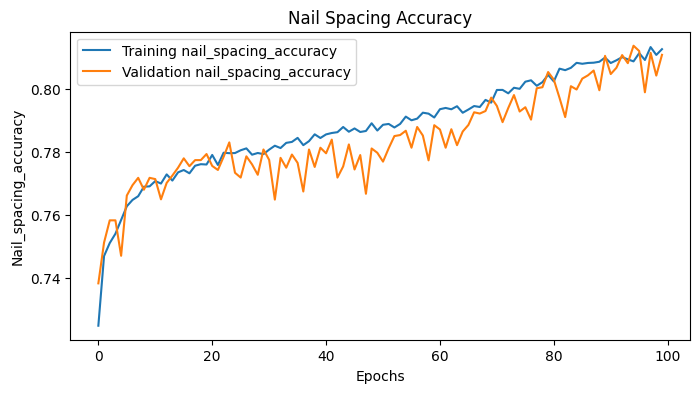

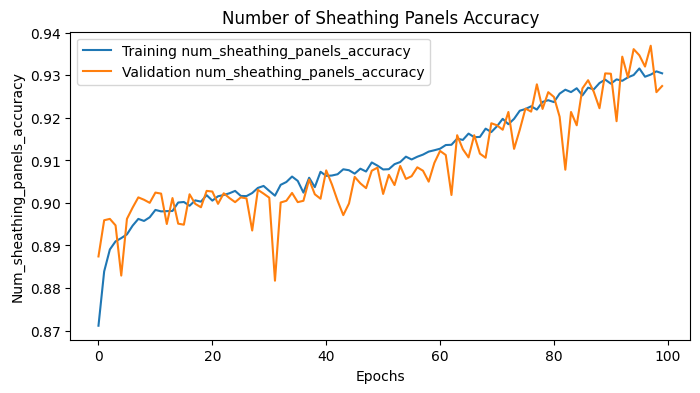

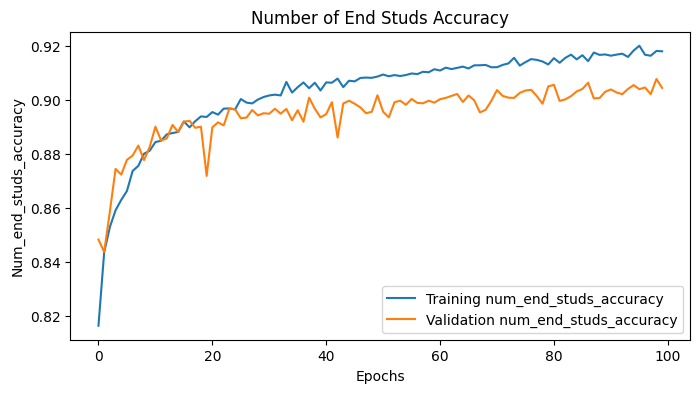

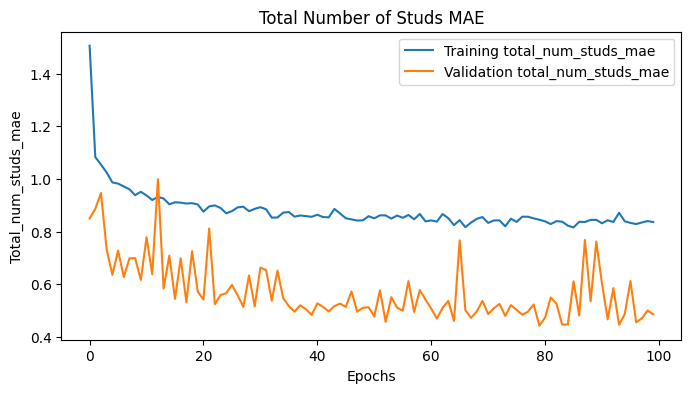

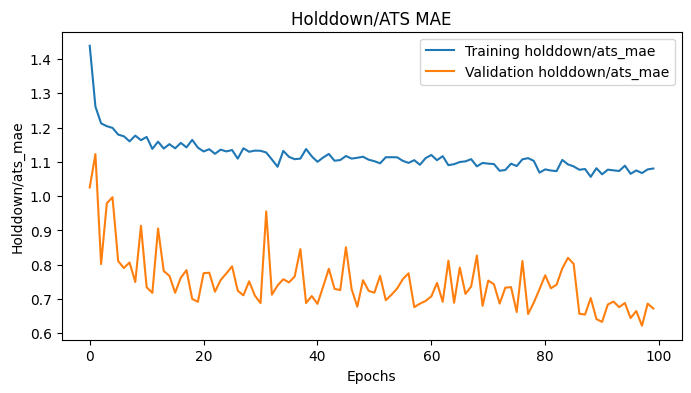

In [36]:
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on test data
eval_result = best_model.evaluate(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                               'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                               'num_end_studs': Y_test_onehot_num_end_studs,
                                               'total_num_studs': Y_test_C_1['Total number studs'],
                                               'holddown/ats': Y_test_C_1['HoldDown Model / ATS']})
print("Evaluation result on Test Data:", eval_result)


# Re-train the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
history = model.fit(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                                  'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                                  'num_end_studs': Y_train_onehot_num_end_studs,
                                  'total_num_studs': Y_train_C_1['Total number studs'],
                                  'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
                    epochs=100,  # Number of epochs
                    validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                                  'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                                  'num_end_studs': Y_test_onehot_num_end_studs,
                                                  'total_num_studs': Y_test_C_1['Total number studs'],
                                                  'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}))

# Function to plot metrics
def plot_metrics(history, metric_name, title):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric_name], label=f'Training {metric_name}')
    plt.plot(history.history[f'val_{metric_name}'], label=f'Validation {metric_name}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.show()

# Plot for each output
plot_metrics(history, 'nail_spacing_accuracy', 'Nail Spacing Accuracy')
plot_metrics(history, 'num_sheathing_panels_accuracy', 'Number of Sheathing Panels Accuracy')
plot_metrics(history, 'num_end_studs_accuracy', 'Number of End Studs Accuracy')
plot_metrics(history, 'total_num_studs_mae', 'Total Number of Studs MAE')
plot_metrics(history, 'holddown/ats_mae', 'Holddown/ATS MAE')
